In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB3
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import plot_model

# Constants
labels = ['AD', 'CONTROL', 'PD']
image_size = 150

# Replace this line with the correct path to the root of your dataset
dataset_path = 'Training/'

# Load images and labels
X = []
Y = []

for label in labels:
    for subset in ['Training', 'test']:
        subset_path = os.path.join(dataset_path, label)
        for image_name in tqdm(os.listdir(subset_path), desc=f"Loading {subset}/{label} images"):
            image_path = os.path.join(subset_path, image_name)
            image = cv2.imread(image_path)
            
            # Skip if the image is not readable or invalid
            if image is None or image.size == 0 or image.shape[0] == 0 or image.shape[1] == 0:
                print(f"Error or invalid image: {image_path}")
                continue
            # ... rest of the code

            
            
            image = cv2.resize(image, (image_size, image_size))
            X.append(image)
            Y.append(labels.index(label))

X = np.array(X)
Y = np.array(Y)

# Shuffle and split the data
X, Y = shuffle(X, Y, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Convert labels to one-hot encoding
y_train_new = to_categorical(Y_train, len(labels))
y_test_new = to_categorical(Y_test, len(labels))

# Create EfficientNetB3 model
efficientnet_B3 = EfficientNetB3(include_top=False,
                                weights='imagenet',
                                input_shape=(image_size, image_size, 3))

model = efficientnet_B3.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(len(labels), activation='softmax')(model)

model = tf.keras.models.Model(inputs=efficientnet_B3.input, outputs=model)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
tensorBoard = TensorBoard(log_dir="logs")
checkPoint = ModelCheckpoint("efficient_net_B3.h5",
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=2,
                              verbose=1,
                              mode='auto',
                              min_delta=0.001)
es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   verbose=1,
                   mode='auto',
                   restore_best_weights=True)

# Train the model
history = model.fit(X_train,
                    y_train_new,
                    batch_size=32,
                    validation_split=0.1,
                    epochs=30,
                    verbose=1,
                    callbacks=[tensorBoard, checkPoint, reduce_lr, es])



Loading test/PD images: 100%|██████████| 906/906 [00:00<00:00, 3226.30it/s]


Epoch 1/30
149/149 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.8124
Epoch 1: val_loss improved from inf to 0.73977, saving model to efficient_net_B3.h5


/Users/atulkumar/miniconda3/envs/mac/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


149/149 [==============================] - 297s 2s/step - loss: 0.4449 - accuracy: 0.8124 - val_loss: 0.7398 - val_accuracy: 0.8539 - lr: 0.0010
Epoch 2/30
149/149 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9224
Epoch 2: val_loss improved from 0.73977 to 0.39933, saving model to efficient_net_B3.h5
149/149 [==============================] - 275s 2s/step - loss: 0.2189 - accuracy: 0.9224 - val_loss: 0.3993 - val_accuracy: 0.8387 - lr: 0.0010
Epoch 3/30
149/149 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9507
Epoch 3: val_loss did not improve from 0.39933
149/149 [==============================] - 261s 2s/step - loss: 0.1360 - accuracy: 0.9507 - val_loss: 0.7920 - val_accuracy: 0.5863 - lr: 0.0010
Epoch 4/30
149/149 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9741
Epoch 4: val_loss improved from 0.39933 to 0.09717, saving model to efficient_net_B3.h5
149/149 [==============================] - 254s 2s/ste

19/19 [==============================] - 6s 329ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       181
           2       1.00      1.00      1.00       192

    accuracy                           1.00       586
   macro avg       1.00      1.00      1.00       586
weighted avg       1.00      1.00      1.00       586



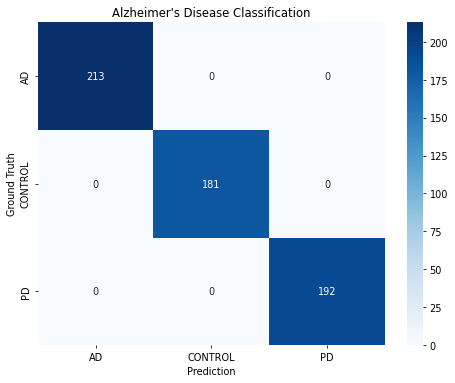

/Users/atulkumar/miniconda3/envs/mac/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [3]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Evaluate the model
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(y_test_new, axis=1)
print(classification_report(actual_label, pred))

# Confusion matrix
cnf = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8, 6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Alzheimer\'s Disease Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

# Save and load the model
saved_model_path = "./efficient_net_B3.h5"
model.save(saved_model_path)

saved_model = tf.keras.models.load_model(saved_model_path)


